In [1]:
import pandas as pd
import pickle
from collections import Counter
import sklearn.cluster as cluster
from config import OUTPUT_WITH_EMBEDDING_PICKLE_PATH, WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, RISK_1_COLUMN, EMBEDDING_COLUMN, MIN_REASON_COUNT_TO_KEEP

In [5]:
with open(OUTPUT_WITH_EMBEDDING_PICKLE_PATH, "rb") as f:
    relevant_df = pickle.load(f)

(6602, 3)

In [11]:
print(f"Ideally we would like to have ~{len(set(relevant_df[RISK_1_COLUMN]))} clusters")

Ideally we would like to have ~26 clusters


In [13]:
relevant_df.sample(7)

,why.not.ethical_clean,Risk 1,embedding
3416,Releasing personally identifiable information ...,dp&p uninformed consent,"[0.01954994, -0.00023918178, 0.023548925, -0.0..."
2137,I do believe it is up to the company to ensure...,other limitation of liability,"[-0.011514745, 0.06439858, 0.008812788, -0.041..."
4443,the consumer should have a say in the data ret...,storage and retention of personal data,"[0.02174863, -0.0050867074, -0.011893639, -0.0..."
3751,"""Any of the terms"" may be too ahrsh to lead to...",onesided terms,"[0.023310382, -0.0012479649, -0.010767342, -0...."
3255,"This paragraph contains quite a bit of jargon,...",limited readability,"[0.007843671, -0.03445617, 0.0049423636, -0.00..."
1643,They will disclose user information to third p...,third party data transfers,"[0.008943186, 0.0047789407, 0.027321154, 0.012..."
626,They state that you are liable for all activit...,onesided terms,"[-0.02522809, 0.03919027, 0.038867038, 0.01967..."


In [14]:
embeddings = list(relevant_df[EMBEDDING_COLUMN])

In [15]:
%%time
# todo: use different number components and see effects
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 2min 1s, sys: 1.93 s, total: 2min 3s
Wall time: 25.9 s


In [16]:
import hdbscan
clusters = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)
# somehow all clusters are -1. add more data

/tmp/ipykernel_181046/4250487669.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


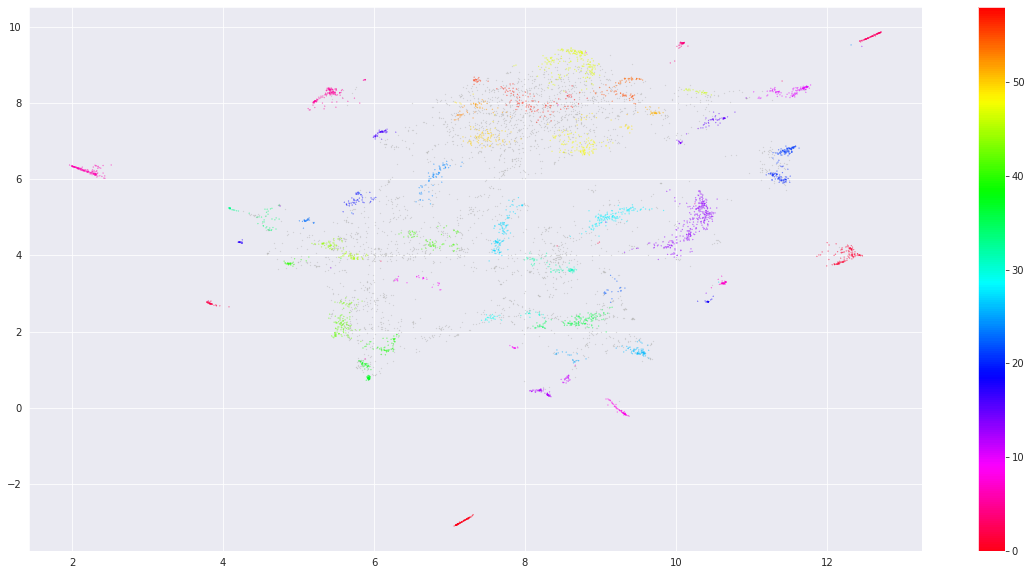

In [17]:
import matplotlib.pyplot as plt

# Prepare data
umap_2d_embedding = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_2d_embedding, columns=['x', 'y'])
result['labels'] = clusters.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [22]:
result.sample(5)

,x,y,labels
1805,9.120101,7.151499,-1
3072,9.665906,1.678823,-1
597,5.839782,1.787161,-1
2662,7.150724,7.670679,53
2616,7.763958,7.142442,-1


In [23]:
from collections import Counter
Counter(result["labels"]).most_common()

[(-1, 2914),
 (13, 325),
 (47, 193),
 (6, 144),
 (5, 139),
 (28, 137),
 (1, 132),
 (27, 124),
 (48, 115),
 (10, 113),
 (36, 109),
 (0, 98),
 (42, 97),
 (3, 95),
 (21, 91),
 (57, 81),
 (50, 76),
 (26, 76),
 (20, 75),
 (41, 73),
 (8, 69),
 (24, 68),
 (12, 65),
 (39, 58),
 (44, 53),
 (19, 50),
 (16, 49),
 (15, 48),
 (45, 46),
 (7, 45),
 (55, 44),
 (37, 43),
 (4, 43),
 (2, 42),
 (9, 38),
 (32, 38),
 (54, 36),
 (49, 35),
 (34, 33),
 (38, 33),
 (40, 31),
 (51, 31),
 (52, 30),
 (31, 29),
 (46, 26),
 (11, 25),
 (23, 24),
 (35, 24),
 (29, 24),
 (33, 23),
 (25, 23),
 (43, 22),
 (18, 21),
 (22, 19),
 (17, 19),
 (53, 19),
 (56, 19),
 (14, 18),
 (30, 17),
 (58, 15)]

In [52]:
# c-TF-IDF (clss Term Frequency Inverse Document Frequency

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

docs_df = pd.DataFrame(relevant_df, columns=[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN])
docs_df['Topic'] = clusters.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby('Topic', as_index = False).agg({WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN: ' '.join})

In [54]:
tf_idf, count = c_tf_idf(docs_per_topic[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN].values, m=len(relevant_df))

In [64]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN]
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN: "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(3), topic_sizes.shape

/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(    Topic  Size
 0      -1  2914
 14     13   325
 48     47   193,
 (60, 2))

In [62]:
n_words_to_check = 10
topic_to_check = 1
top_n_words[topic_to_check][:n_words_to_check]

[('age', 0.20071262644409787),
 ('children', 0.1647760320169367),
 ('13', 0.11726279839058341),
 ('16', 0.08655668374893509),
 ('child', 0.07729393515683748),
 ('18', 0.07546412129377379),
 ('parent', 0.05824114568188213),
 ('parents', 0.050802621262837785),
 ('minors', 0.048537425186758486),
 ('block', 0.04032079316437994)]

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

# reducing number of topics (topic reduction)
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values(WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN, ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN: ' '.join})

    # Calculate new topic words
    m = len(relevant_df)
    tf_idf, count = c_tf_idf(docs_per_topic[WHY_NOT_ETHICAL_CLEAN_TEXT_COLUMN].values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(10)

/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/amit/python_envs/nlp_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87:

,Topic,Size
0,-1,2978
14,13,325
34,33,193
23,22,184
26,25,169
39,38,145
7,6,144
6,5,139
11,10,139
2,1,132
